# Lid-Driven Cavity case (LDC)

This test case considers a box with a moving lid, where the velocity is initially at rest.

We start by loading IncompressibleNavierStokes and a Makie plotting backend.

In [1]:
using IncompressibleNavierStokes

if haskey(ENV, "GITHUB_ACTIONS")
    using CairoMakie
else
    using GLMakie
end

## Build problem

We may choose the floating point type for the simulations. Replacing `Float64` with
`Float32` will not necessarilily speed up the simulations, but requires half as much
memory.

In [2]:
T = Float64

Float64

Available viscosity models are:

- `LaminarModel`,
- `KEpsilonModel`,
- `MixingLengthModel`,
- `SmagorinskyModel`, and
- `QRModel`.

They all take a Reynolds number as a parameter. Here we choose a moderate Reynolds number.

In [3]:
viscosity_model = LaminarModel{T}(; Re = 1000)

LaminarModel{Float64}(1000.0)

Available convection models are:

- `NoRegConvectionModel`,
- `C2ConvectionModel`,
- `C4ConvectionModel`, and
- `LerayConvectionModel`.

We here take the simplest model.

In [4]:
convection_model = NoRegConvectionModel{T}()

NoRegConvectionModel{Float64}()

We create a two-dimensional domain with a box of size `[1, 1]`.

In [5]:
Nx = 100                          # Number of x-volumes
Ny = 100                          # Number of y-volumes
grid = create_grid(
    T,
    Nx,
    Ny;
    xlims = (0, 1),               # Horizontal limits (left, right)
    ylims = (0, 1),               # Vertical limits (bottom, top)
    stretch = (1, 1),             # Stretch factor (sx, sy)
)

Grid{Float64, 2}(100, 100, 1, (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], Float64[], [0.005, 0.015000000000000001, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095  …  0.905, 0.915, 0.9249999999999999, 0.9349999999999999, 0.9450000000000001, 0.955, 0.965, 0.9749999999999999, 0.9850000000000001, 0.995], [0.005, 0.015000000000000001, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095  …  0.905, 0.915, 0.9249999999999999, 0.9349999999999999, 0.9450000000000001, 0.955, 0.965, 0.9749999999999999, 0.9850000000000001, 0.995], Float64[], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], Float64[], F

Solver settings are used by certain implicit solvers.

In [6]:
solver_settings = SolverSettings{T}(;
    pressure_solver = DirectPressureSolver{T}(),    # Pressure solver
    p_add_solve = true,                             # Additional pressure solve for second order pressure
    abstol = 1e-10,                                 # Absolute accuracy
    reltol = 1e-14,                                 # Relative accuracy
    maxiter = 10,                                   # Maximum number of iterations
    newton_type = :approximate,
)

SolverSettings{Float64}(DirectPressureSolver{Float64}(SuiteSparse.CHOLMOD.Factor{Float64}
type:    LLt
method:  simplicial
maxnnz:  1
nnz:     0
success: true
), true, 1.0e-10, 1.0e-14, 10, :approximate, false)

Dirichlet boundary conditions are specified as plain Julia functions. They are marked by
the `:dirichlet` symbol. Other possible BC types are `:periodic`, `:symmetric`, and `:pressure`.

In [7]:
u_bc(x, y, t, setup) = y ≈ setup.grid.ylims[2] ? 1.0 : 0.0
v_bc(x, y, t, setup) = zero(x)
bc = create_boundary_conditions(
    T,
    u_bc,
    v_bc;
    bc_unsteady = false,
    bc_type = (;
        u = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
        v = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
        k = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
        e = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
        ν = (; x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)),
    ),
)

BC{Float64}(false, (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), NamedTuple(), (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), (x = (:dirichlet, :dirichlet), y = (:dirichlet, :dirichlet)), Main.##275.u_bc, Main.##275.v_bc, IncompressibleNavierStokes.var"#92#120"(), IncompressibleNavierStokes.var"#93#121"(), IncompressibleNavierStokes.var"#94#122"(), IncompressibleNavierStokes.var"#95#123"(), (x = (0, 0), y = (0, 0)), (x = (0, 0), y = (0, 0)), (x = (0, 0), y = (0, 0)), IncompressibleNavierStokes.var"#96#124"())

The body forces are specified as plain Julia functions.

In [8]:
bodyforce_u(x, y) = 0
bodyforce_v(x, y) = 0
force = SteadyBodyForce{T}(; bodyforce_u, bodyforce_v)

SteadyBodyForce{Float64}(Main.##275.bodyforce_u, Main.##275.bodyforce_v, IncompressibleNavierStokes.var"#18#30"(), Float64[])

We may now assemble our setup.

In [9]:
setup = Setup{T,2}(; viscosity_model, convection_model, grid, force, solver_settings, bc)

Setup{Float64, 2}(LaminarModel{Float64}(1000.0), NoRegConvectionModel{Float64}(), Grid{Float64, 2}(100, 100, 1, (0.0, 1.0), (0.0, 1.0), (0.0, 1.0), [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], Float64[], [0.005, 0.015000000000000001, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095  …  0.905, 0.915, 0.9249999999999999, 0.9349999999999999, 0.9450000000000001, 0.955, 0.965, 0.9749999999999999, 0.9850000000000001, 0.995], [0.005, 0.015000000000000001, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095  …  0.905, 0.915, 0.9249999999999999, 0.9349999999999999, 0.9450000000000001, 0.955, 0.965, 0.9749999999999999, 0.9850000000000001, 0.995], Float64[], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, Float64[], Float64[], Float64

The discrete operators are built with the `build_operators!` function.

In [10]:
build_operators!(setup);

We will solve for a time interval of ten seconds.

In [11]:
t_start, t_end = tlims = (0.0, 10.0)

(0.0, 10.0)

The initial conditions are defined as plain Julia functions.

In [12]:
initial_velocity_u(x, y) = 0
initial_velocity_v(x, y) = 0
initial_pressure(x, y) = 0
V₀, p₀ = create_initial_conditions(
    setup,
    t_start;
    initial_velocity_u,
    initial_velocity_v,
    initial_pressure,
);

We may also define a list of iteration processors. They are processed after every
`nupdate` iteration.

In [13]:
logger = Logger(; nupdate = 10)
real_time_plotter = RealTimePlotter(; nupdate = 5, fieldname = :vorticity)
tracer = QuantityTracer(; nupdate = 1)
processors = [logger, real_time_plotter, tracer]

3-element Vector{IncompressibleNavierStokes.Processor}:
 Logger(10)
 RealTimePlotter(5, :vorticity, Observable{Nothing} with 0 listeners. Value:
nothing)
 QuantityTracer(1, Float64[], Float64[], Float64[], Float64[], Float64[], Float64[])

## Solve problems

There are many different problems. They can all be solved by calling the `solve`
function.

A `SteadyStateProblem` is for computing a state where the right hand side of the
momentum equation is zero.

In [14]:
problem = SteadyStateProblem(setup, V₀, p₀);
V, p = @time solve(problem; processors);

Initial momentum residual = 0.001959700502304355
Iteration 1: momentum residual = 0.001231395188483114
Iteration 2: momentum residual = 0.00036971660713867307
Iteration 3: momentum residual = 5.9744826258877374e-5
Iteration 4: momentum residual = 1.932529935631683e-5
Iteration 5: momentum residual = 3.3496153503953925e-6
Iteration 6: momentum residual = 5.089010398338933e-7
Iteration 7: momentum residual = 4.362434397823644e-10
Iteration 8: momentum residual = 8.54852755423352e-16
  5.182183 seconds (5.72 M allocations: 1.296 GiB, 11.61% gc time, 48.97% compilation time)


For this test case, the same steady state may be obtained by solving an
`UnsteadyProblem` for a sufficiently long time. A ODE method is needed in this
case. Here we will opt for a standard fourth order Runge-Kutta method with a fixed time
step.

n = 0, t = 0.0, maxres = 0.001959700502304355
n = 10, t = 0.09999999999999999, maxres = 0.00025319871038233526
n = 20, t = 0.20000000000000004, maxres = 0.00014909179652946138
n = 30, t = 0.3000000000000001, maxres = 0.00012328447970430485
n = 40, t = 0.4000000000000002, maxres = 0.00010852932167232967
n = 50, t = 0.5000000000000002, maxres = 9.69291535410219e-5
n = 60, t = 0.6000000000000003, maxres = 8.636923645366355e-5
n = 70, t = 0.7000000000000004, maxres = 7.906742786030515e-5
n = 80, t = 0.8000000000000005, maxres = 7.203191485044647e-5
n = 90, t = 0.9000000000000006, maxres = 6.636747738725159e-5
n = 100, t = 1.0000000000000007, maxres = 6.166360764356111e-5
n = 110, t = 1.1000000000000008, maxres = 5.783323283117426e-5
n = 120, t = 1.2000000000000008, maxres = 5.406965823050935e-5
n = 130, t = 1.300000000000001, maxres = 5.1102732372013186e-5
n = 140, t = 1.400000000000001, maxres = 4.970653541013073e-5
n = 150, t = 1.500000000000001, maxres = 4.8072444975413866e-5
n = 160, t

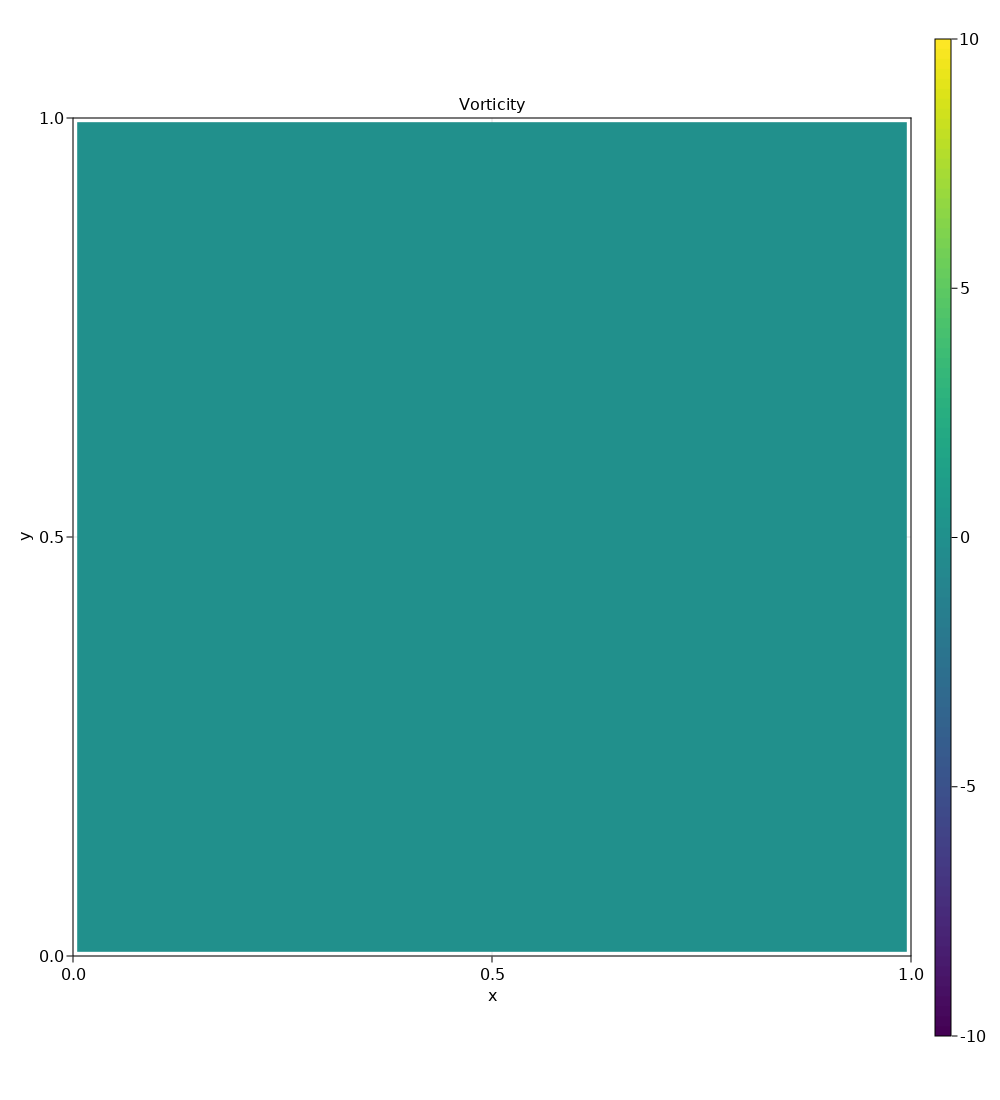

In [15]:
problem = UnsteadyProblem(setup, V₀, p₀, tlims);
V, p = @time solve(problem, RK44(); Δt = 0.01, processors);

## Postprocess

The `tracer` object contains a history of some quantities related to the momentum and
energy.

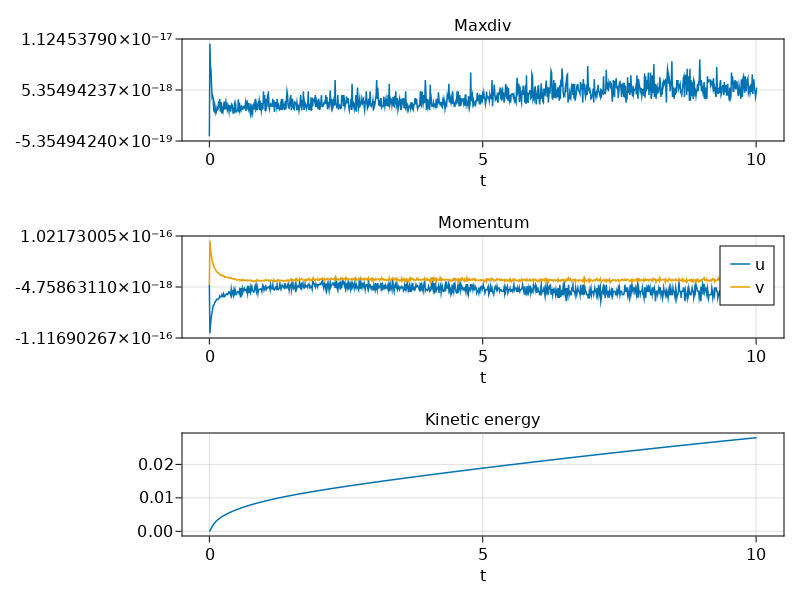

In [16]:
plot_tracers(tracer)

We may also plot the final pressure field,

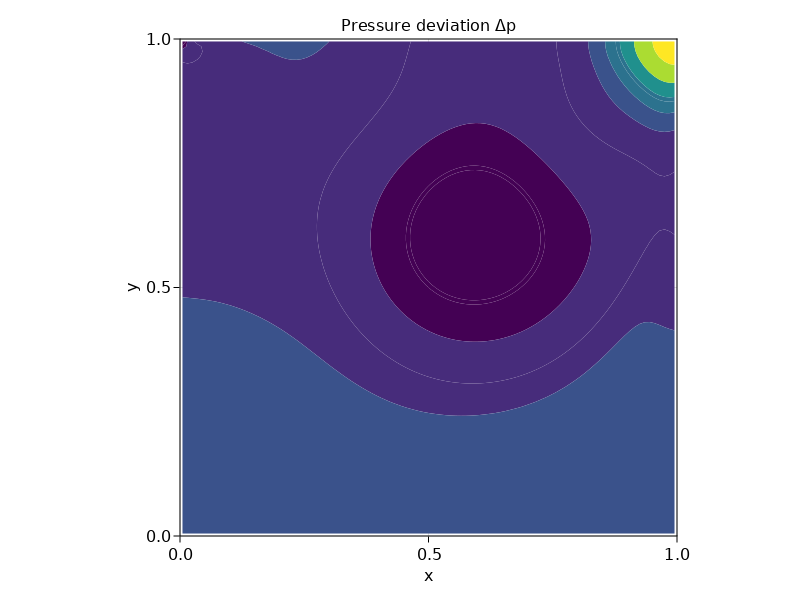

In [17]:
plot_pressure(setup, p)

vorticity field,

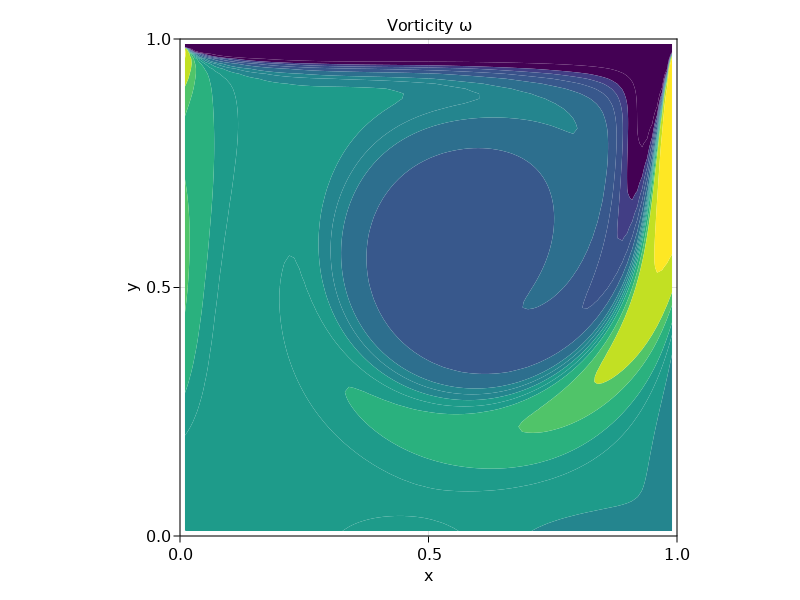

In [18]:
plot_vorticity(setup, V, tlims[2])

or streamfunction.

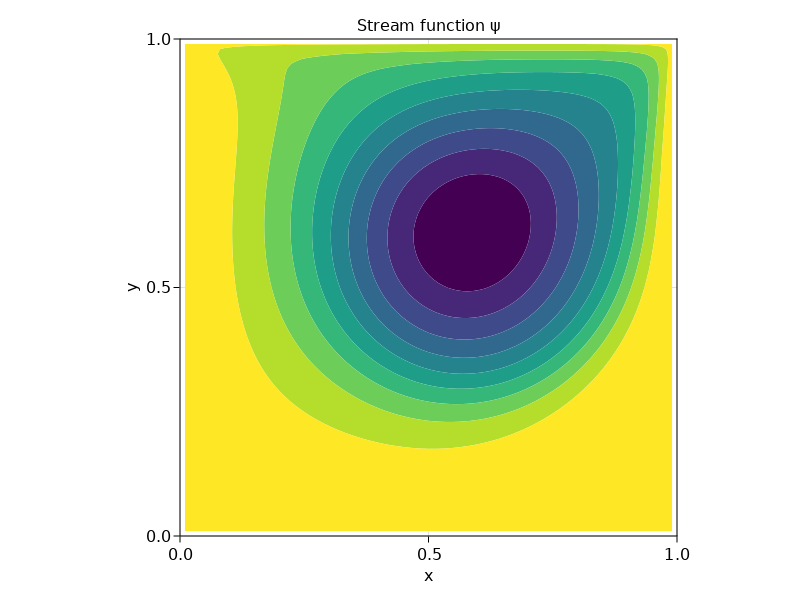

In [19]:
plot_streamfunction(setup, V, tlims[2])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*